In [2]:
# EDA inicial — Focos de Queimadas (2019–2024)
# Este notebook carrega os CSVs em data/raw/, consolida e gera análises e gráficos básicos.

import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configs
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", context="notebook")

# Resolver diretórios de forma robusta (notebook não tem __file__)
if "__file__" in globals():
    PROJECT_ROOT = Path(__file__).resolve().parents[1]
else:
    # Se estiver rodando de dentro de notebooks/, subir 1 nível
    cwd = Path.cwd().resolve()
    PROJECT_ROOT = cwd.parent if cwd.name == "notebooks" else cwd

RAW_DIR = PROJECT_ROOT / "data" / "raw"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Raw dir:", RAW_DIR)
print("Processed dir:", PROCESSED_DIR)


Project root: /Users/fredericoborges/Pythons/projeto_aplicado_grupo_12
Raw dir: /Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw
Processed dir: /Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/processed


In [3]:
# Listar CSVs disponíveis e carregar
csv_files = sorted(RAW_DIR.glob("*.csv"))
if not csv_files:
    raise FileNotFoundError(f"Nenhum CSV encontrado em {RAW_DIR}. Coloque arquivos .csv no diretório e reexecute.")

csv_files


[PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2019.csv'),
 PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2020.csv'),
 PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2021.csv'),
 PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2022.csv'),
 PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2023.csv'),
 PosixPath('/Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/raw/focos_ams_ref_2024.csv')]

In [4]:
# Carregar e concatenar
usecols = None  # ou liste colunas específicas para otimizar

frames = []
for fp in csv_files:
    try:
        df = pd.read_csv(fp, encoding="utf-8", sep=",", usecols=usecols, low_memory=False)
    except UnicodeDecodeError:
        df = pd.read_csv(fp, encoding="latin1", sep=",", usecols=usecols, low_memory=False)
    df["_source_file"] = fp.name
    frames.append(df)

raw = pd.concat(frames, ignore_index=True)
raw.shape


(2364956, 10)

In [5]:
# Limpeza mínima: normalizar nomes e datas
# Tentativa de detectar colunas padrões: data, bioma, estado/UF, municipio
cols = {c.lower(): c for c in raw.columns}

def get_col(*cands):
    for c in cands:
        if c in cols:
            return cols[c]
    return None

col_date = get_col("data_pas", "data", "dt", "datetime")
col_bioma = get_col("bioma")
col_uf = get_col("estado", "uf")
col_muni = get_col("municipio", "município", "munic")

if col_date is None:
    raise KeyError("Não encontrei coluna de data (ex.: data_pas). Atualize o mapeamento.")

raw["date"] = pd.to_datetime(raw[col_date], errors="coerce")
if raw["date"].isna().all():
    raise ValueError("Falha ao converter datas. Verifique o formato em data_pas.")

# Normalização simples de texto
for c in [col_bioma, col_uf, col_muni]:
    if c and c in raw.columns:
        raw[c] = raw[c].astype(str).str.strip()

raw["year"] = raw["date"].dt.year
raw["month"] = raw["date"].dt.to_period("M").astype(str)
raw["day"] = raw["date"].dt.date

raw.head()


,id_bdq,foco_id,lat,lon,data_pas,pais,estado,municipio,bioma,_source_file,date,year,month,day
0,1073534841,01875fcd-0102-3dee-ac16-011708c4936e,-19.590,-42.489,2019-05-24 16:35:00,Brasil,MINAS GERAIS,BOM JESUS DO GALHO,Mata Atlântica,focos_ams_ref_2019.csv,2019-05-24 16:35:00,2019,2019-05,2019-05-24
1,1073534840,515287b9-b500-37f8-a169-298c5c4b660e,-19.992,-43.261,2019-05-24 16:35:00,Brasil,MINAS GERAIS,SANTA BÁRBARA,Mata Atlântica,focos_ams_ref_2019.csv,2019-05-24 16:35:00,2019,2019-05,2019-05-24
2,792624607,27258f85-5061-3f65-83f6-c42e1522b33b,-19.057,-63.225,2019-01-02 18:00:00,Bolivia,Santa Cruz,Cordillera,nan,focos_ams_ref_2019.csv,2019-01-02 18:00:00,2019,2019-01,2019-01-02
3,792624606,845b7a0a-78f6-3beb-bd47-04275d9e147b,-19.786,-62.861,2019-01-02 18:00:00,Bolivia,Santa Cruz,Cordillera,nan,focos_ams_ref_2019.csv,2019-01-02 18:00:00,2019,2019-01,2019-01-02
4,792624605,48faa080-d75b-3a2b-857d-c1c923332a81,-21.726,-63.111,2019-01-02 18:00:00,Bolivia,Tarija,Gran Chaco,nan,focos_ams_ref_2019.csv,2019-01-02 18:00:00,2019,2019-01,2019-01-02


In [6]:
# Sumários básicos
print("Linhas:", len(raw))
print("Colunas:", raw.shape[1])
print("Período:", raw['date'].min(), "->", raw['date'].max())

# Contagem diária total
by_day = raw.groupby('day').size().rename('focos').reset_index()
by_day.head(), by_day.tail()


Linhas: 2364956
Colunas: 14
Período: 2019-01-01 15:40:00 -> 2024-12-31 17:58:00


(          day  focos
 0  2019-01-01    184
 1  2019-01-02    613
 2  2019-01-03    335
 3  2019-01-04   1010
 4  2019-01-05    359,
              day  focos
 2169  2024-12-27    769
 2170  2024-12-28    547
 2171  2024-12-29    214
 2172  2024-12-30    741
 2173  2024-12-31     81)

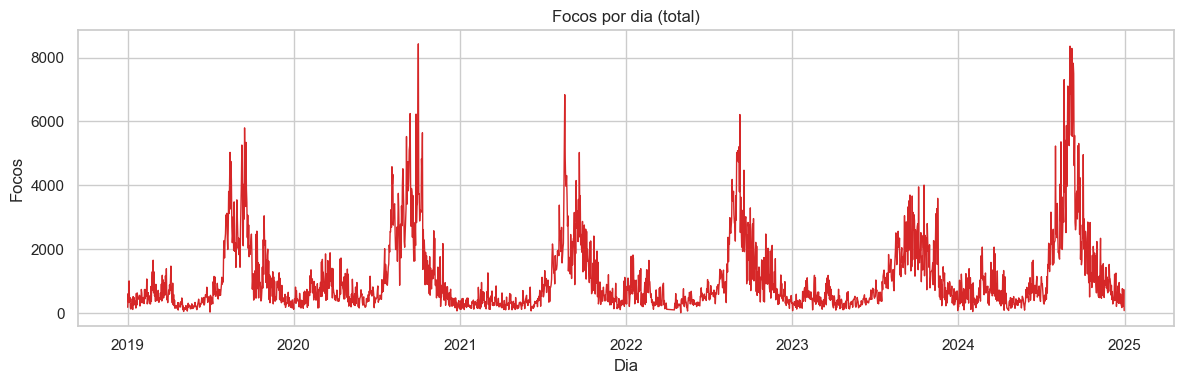

In [7]:
# Gráficos: série temporal diária (total)
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(by_day['day'], by_day['focos'], color='tab:red', linewidth=1)
ax.set_title('Focos por dia (total)')
ax.set_xlabel('Dia')
ax.set_ylabel('Focos')
plt.tight_layout()
plt.show()


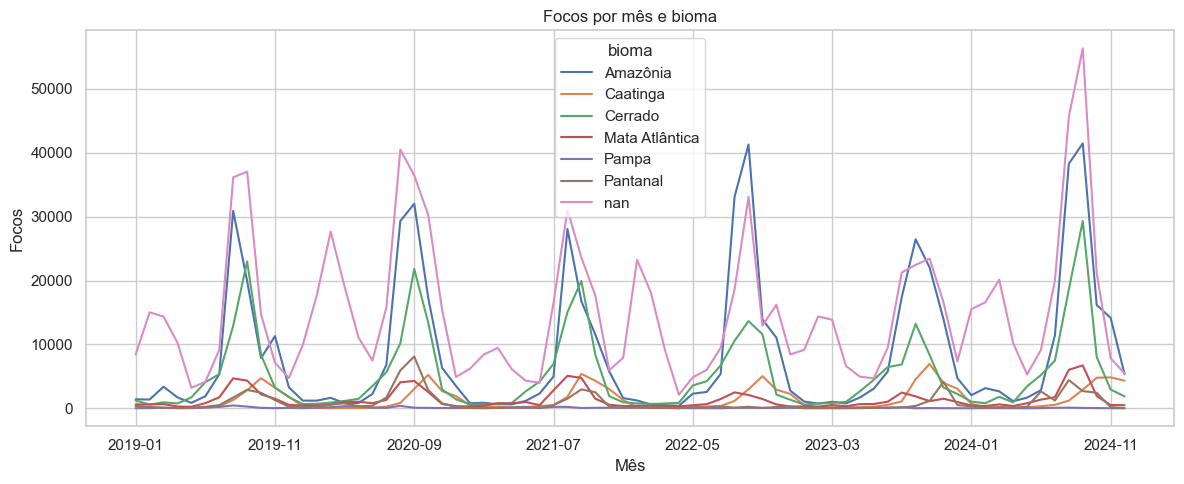

/var/folders/84/pt2y_7m14gnf6s_51zpxgl080000gn/T/ipykernel_52735/1418045132.py:19: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


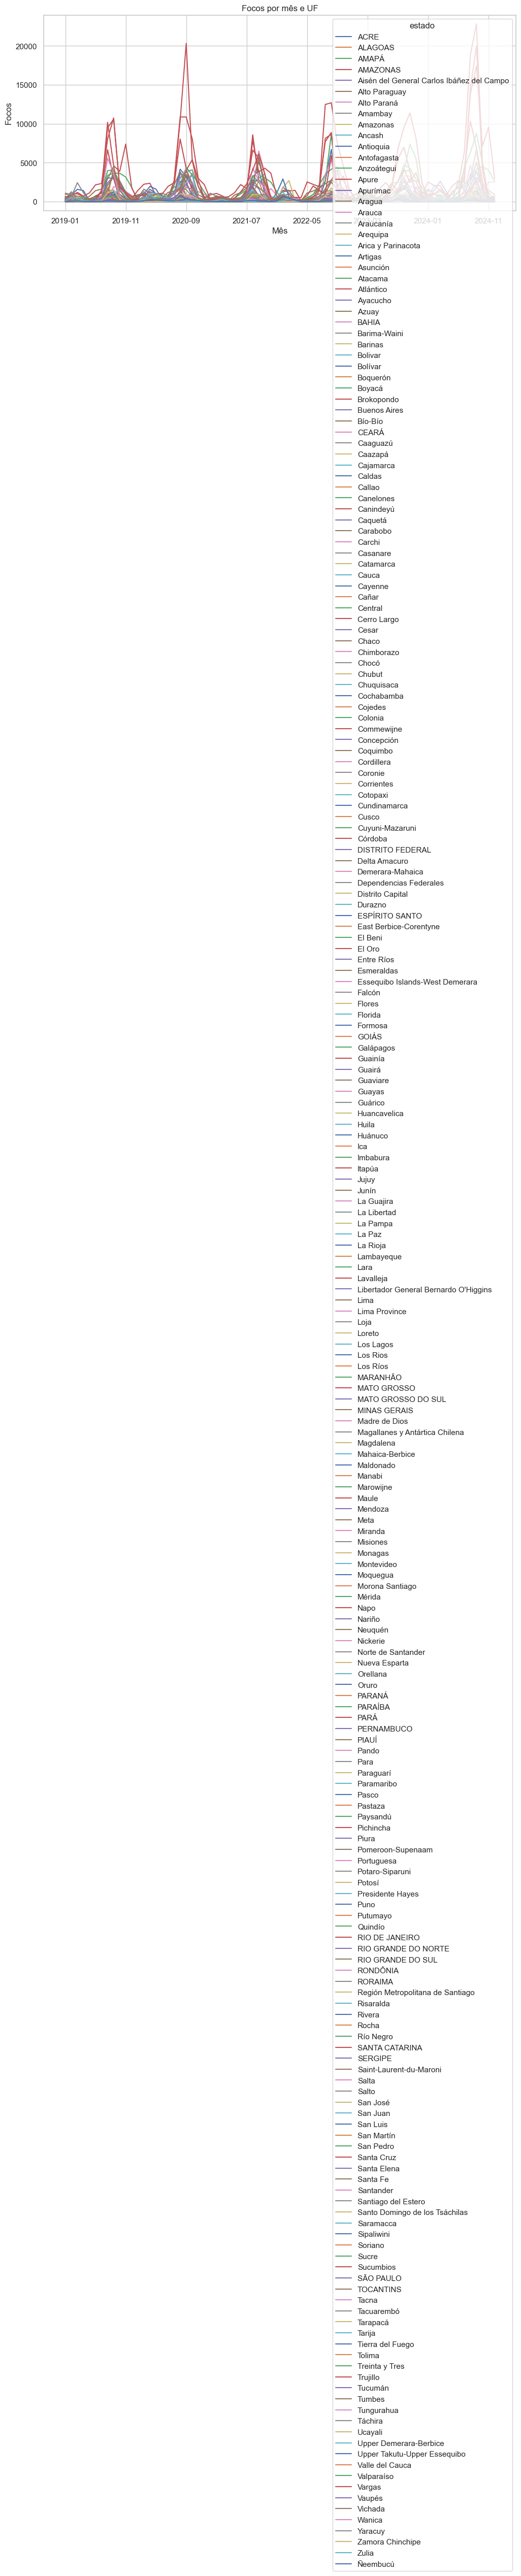

2

In [8]:
# Agregações por bioma e UF (se existirem)
plots = []
if col_bioma and col_bioma in raw.columns:
    by_bioma = raw.groupby([col_bioma, 'month']).size().rename('focos').reset_index()
    pivot_bioma = by_bioma.pivot(index='month', columns=col_bioma, values='focos').fillna(0)
    plots.append(('Focos por mês e bioma', pivot_bioma))

if col_uf and col_uf in raw.columns:
    by_uf = raw.groupby([col_uf, 'month']).size().rename('focos').reset_index()
    pivot_uf = by_uf.pivot(index='month', columns=col_uf, values='focos').fillna(0)
    plots.append(('Focos por mês e UF', pivot_uf))

for title, pv in plots:
    fig, ax = plt.subplots(figsize=(12, 5))
    pv.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Mês')
    ax.set_ylabel('Focos')
    plt.tight_layout()
    plt.show()

len(plots)


In [9]:
# Exportar artefatos mínimos
by_day.to_csv(PROCESSED_DIR / "focos_por_dia.csv", index=False)
if 'pivot_bioma' in globals():
    pivot_bioma.to_csv(PROCESSED_DIR / "focos_mes_bioma.csv")
if 'pivot_uf' in globals():
    pivot_uf.to_csv(PROCESSED_DIR / "focos_mes_uf.csv")
print("Arquivos exportados em:", PROCESSED_DIR)


Arquivos exportados em: /Users/fredericoborges/Pythons/projeto_aplicado_grupo_12/data/processed
